In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
PATH = 'SlumClassifier'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

print(total_test, total_val, total_train)

batch_size = 50
IMG_HEIGHT = 838
IMG_WIDTH = 768

20 8 236


In [3]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
                    train_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='binary',
                    classes=['notslum-imgs', 'slum-imgs'])
val_data_gen = validation_image_generator.flow_from_directory(
                    validation_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=4,
                    class_mode='binary',
                    classes=['notslum-imgs', 'slum-imgs'])
test_data_gen = test_image_generator.flow_from_directory(
                    PATH,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=20,
                    classes=['test'],
                    shuffle=False)

Found 236 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 20 images belonging to 1 classes.


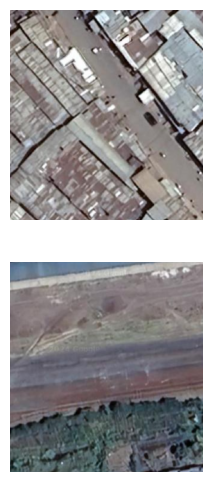

In [4]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:2])

Found 236 images belonging to 2 classes.


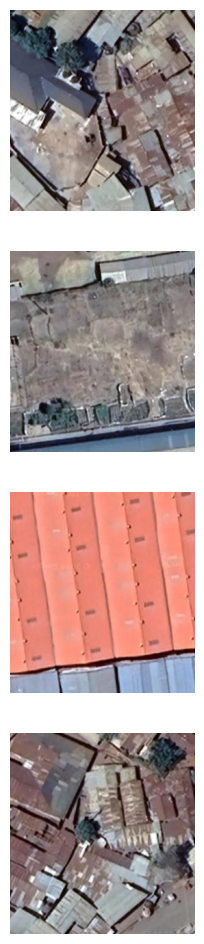

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255,                         
                                            horizontal_flip=True,
                                            vertical_flip=True,)

train_data_gen = train_image_generator.flow_from_directory(
                    train_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='binary',
                    classes=['notslum-imgs', 'slum-imgs'])

augmented_images = [train_data_gen[0][0][i] for i in range(4)]

plotImages(augmented_images)

In [6]:
model = Sequential()
model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(Conv2D(64, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 836, 766, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 418, 383, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 416, 381, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 208, 190, 128)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 206, 188, 64)      73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 103, 94, 64)      0

In [7]:
history = model.fit(
            train_data_gen,
            steps_per_epoch=int(total_train/100),
            validation_data=val_data_gen,
            validation_steps=int(total_val/4),
            epochs=3
            )

Epoch 1/3


2024-02-28 02:33:46.199918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-28 02:33:46.234668: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - ETA: 0s - loss: 3.1371 - accuracy: 0.5233  

2024-02-28 02:44:33.654591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 652s 242s/step - loss: 3.1371 - accuracy: 0.5233 - val_loss: 6.8059 - val_accuracy: 0.5000
Epoch 2/3
2/2 [==============================] - 862s 425s/step - loss: 7.0264 - accuracy: 0.4800 - val_loss: 6.5998 - val_accuracy: 0.5000
Epoch 3/3
2/2 [==============================] - 531s 294s/step - loss: 6.6880 - accuracy: 0.4884 - val_loss: 6.3733 - val_accuracy: 0.5000


ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

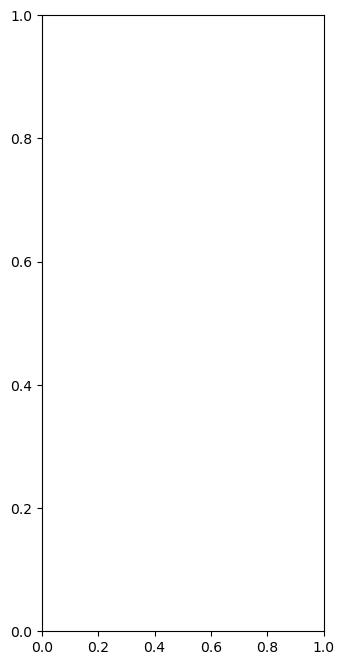

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [10]:
probabilities = model.predict(test_data_gen).flatten()
probabilities

2024-02-28 06:20:44.788709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 10s 10s/step


array([0.9999971, 0.9999971, 0.9999971, 0.9999971, 0.9999971, 0.9999971,
       0.9999971, 0.9999971, 0.9999971, 0.9999971, 0.9999971, 0.9999971,
       0.9999971, 0.9999971, 0.9999971, 0.9999971, 0.9999971, 0.9999971,
       0.9999971, 0.9999971], dtype=float32)

In [11]:
answers =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}%")


Your model correctly identified 50.0%
